# SCORING

In [ ]:
pip install transformers==4.55.2

In [ ]:
# !pip install -U "huggingface_hub[cli]"
!hf auth login --token 

In [4]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("predictions_vinum_infoxlm_top_1_context.csv")

# Filter rows where 'evidence' is NaN
na_samples = df[df['evidence'].isna()]

# Print how many there are
print(f"Number of rows with evidence == NaN: {len(na_samples)}\n")

# Display the first few examples
print(na_samples)


Number of rows with evidence == NaN: 0

Empty DataFrame
Columns: [claim, context, evidence, gold_evidence, gold_label]
Index: []


In [4]:
import os
import re
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# -------------------
# CONFIG
# -------------------
model_name = "ICTuniverse/CafeBERT-QA-vinum-7532-EM"
HF_TOKEN = ""
TEST_CSV = "vinum_test_with_top_1_contexts.csv"
device = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LENGTH = 512

# Sliding window parameters (KEEP EXACTLY YOUR CODE)
WINDOW_SIZE = 480   
MIN_STRIDE = 200     

# -------------------
# Load model + tokenizer
# -------------------
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, token=HF_TOKEN)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, token=HF_TOKEN)
model.to(device)
model.eval()

# -------------------
# Utilities
# -------------------
def normalize_for_em(s):
    if s is None:
        s = ""
    s = str(s).strip().lower()
    s = re.sub(r"[^\w\s]", "", s)
    s = " ".join(s.split())
    return s

def exact_match(pred, gold):
    return int(normalize_for_em(pred) == normalize_for_em(gold))

def tok_len_pair(claim, context):
    return tokenizer(
        claim, context, truncation=False, add_special_tokens=True,
        padding=False, return_length=True
    )["length"][0]

def context_ids_no_specials(text):
    return tokenizer(text, add_special_tokens=False)["input_ids"]

def decode_ids(ids):
    return tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

# -------------------
# Sliding window splitter (KEEP EXACTLY YOUR VERSION)
# -------------------
def create_subcontexts_sliding_window(claim, context, max_len=MAX_LENGTH):
    if tok_len_pair(claim, context) <= max_len:
        return [context.strip()]

    ctx_ids = context_ids_no_specials(context)
    claim_tok_len = len(tokenizer(claim, add_special_tokens=False)["input_ids"])
    reserve = claim_tok_len + 3
    window_size = min(WINDOW_SIZE, max_len - reserve)

    stride = max(MIN_STRIDE, int(window_size * 0.33))
    step = window_size - stride
    if step <= 0:
        step = max(1, window_size // 2)

    subcontexts = []
    for start in range(0, len(ctx_ids), step):
        end = start + window_size
        window_ids = ctx_ids[start:end]
        window_text = decode_ids(window_ids)

        while tok_len_pair(claim, window_text) > max_len and len(window_ids) > 0:
            window_ids = window_ids[:-1]
            window_text = decode_ids(window_ids)

        if window_text.strip():
            subcontexts.append(window_text.strip())
    return subcontexts

# -------------------
# Answering function
# -------------------
def answer_question(question, context):
    encodings = tokenizer(
        question, context,
        return_tensors="pt",
        truncation="only_second",
        max_length=MAX_LENGTH,
        return_offsets_mapping=True,
        padding=True,
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    offset_mapping = encodings["offset_mapping"][0]

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        start_logits = outputs.start_logits[0]
        end_logits = outputs.end_logits[0]

    start_idx = torch.argmax(start_logits).item()
    end_idx = torch.argmax(end_logits).item()
    if end_idx < start_idx:
        end_idx = start_idx

    if start_idx >= len(offset_mapping) or end_idx >= len(offset_mapping):
        return ""

    start_char, _ = offset_mapping[start_idx].tolist()
    _, end_char = offset_mapping[end_idx].tolist()
    return context[start_char:end_char].strip()

# -------------------
# NEW LOGIC HERE
# -------------------
def evaluate_subcontext_matching(test_csv):
    df = pd.read_csv(test_csv)
    required = {"claim", "context", "evidence", "gold_label"}
    if not required.issubset(df.columns):
        raise ValueError(f"Missing columns: {required}")

    total_rows = len(df)
    matched_rows = 0

    for _, row in tqdm(df.iterrows(), total=total_rows):
        claim = str(row["claim"])
        context = str(row["context"])
        gold = str(row["evidence"]) if not pd.isna(row["evidence"]) else ""

        # Case 1: fits into 512 → standard QA
        if tok_len_pair(claim, context) <= MAX_LENGTH:
            pred = answer_question(claim, context)
            if exact_match(pred, gold):
                matched_rows += 1
            continue
        else:
            # Case 2: long context → sliding window
            subcontexts = create_subcontexts_sliding_window(claim, context)
    
            found_match = False
            for subctx in subcontexts:
                try:
                    pred = answer_question(claim, subctx)
                except:
                    pred = ""
    
                if exact_match(pred, gold):
                    matched_rows += 1
                    found_match = True
                    break  
    
            # if no subcontext matched → do nothing

    print("\n==============================")
    print(f"Total rows: {total_rows}")
    print(f"Matched gold evidence: {matched_rows}")
    print(f"Match rate: {matched_rows / total_rows:.4f}")
    print("==============================\n")


def evaluate_subcontext_matching_longest_subs(test_csv):
    df = pd.read_csv(test_csv)
    required = {"claim", "context", "evidence", "gold_label"}
    if not required.issubset(df.columns):
        raise ValueError(f"Missing columns: {required}")

    total_rows = len(df)
    matched_rows = 0

    for _, row in tqdm(df.iterrows(), total=total_rows):
        claim = str(row["claim"])
        context = str(row["context"])
        gold = str(row["evidence"]) if not pd.isna(row["evidence"]) else ""

        # Case 1: fits into 512 → standard QA
        if tok_len_pair(claim, context) <= MAX_LENGTH:
            pred = answer_question(claim, context)
            if exact_match(pred, gold):
                matched_rows += 1
            continue
        else:
            # Case 2: long context → sliding window
            subcontexts = create_subcontexts_sliding_window(claim, context)
            
            longest_subctx = max(
                subcontexts,
                key=lambda subctx: len(tokenizer(subctx, add_special_tokens=False)["input_ids"])
            )
            try:
                pred = answer_question(claim, longest_subctx)
            except:
                pred = ""
            
            if exact_match(pred, gold):
                matched_rows += 1
                
    print("\n==============================")
    print(f"Total rows: {total_rows}")
    print(f"Matched gold evidence: {matched_rows}")
    print(f"Match rate: {matched_rows / total_rows:.4f}")
    print("==============================\n")

# -------------------
# Run
# -------------------
if __name__ == "__main__":
    evaluate_subcontext_matching(TEST_CSV)


100%|██████████| 1005/1005 [02:15<00:00,  7.40it/s]


Total rows: 1005
Matched gold evidence: 719
Match rate: 0.7154



# PREDICTIONS TOP 1, SLIDING WINDOWS, ViNumFC

Có 3 đoạn code sau mục này
1. format file truy vấn (lấy top 1 context)
2. MRC
3. CLS

In [1]:
import pandas as pd

# paths (as you provided)
TEST_CSV = "/kaggle/input/vinumfc-formatted/test_vinum_formatted.csv"
RANKINGS_TXT = "/kaggle/input/rankings-3-vinum-new/rankings_3_vinum_new.txt"
CORPUS_CSV = "/kaggle/input/raw-ir-vinum/corpus.csv"
OUT_CSV = "vinum_test_with_top_1_contexts.csv"

# load files
test_df = pd.read_csv(TEST_CSV)
corpus_df = pd.read_csv(CORPUS_CSV)

# build corpus map: cid -> context (assumes columns named 'cid' and 'context')
corpus_map = {int(r["cid"]): r["context"] for _, r in corpus_df.iterrows()}

# parse rankings: each line "qid cid1 cid2 ..."
rankings = {}
with open(RANKINGS_TXT, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        qid = int(parts[0])
        cids = [int(x) for x in parts[1:]]
        rankings[qid] = cids

# determine qid per test row: use column 'qid' if present, otherwise 1-based row index
qid_col = None

out_rows = []
for i, row in test_df.iterrows():
    qid = int(row[qid_col]) if qid_col is not None else (i + 1)
    top1_cid = rankings[qid][0]            # top-1 retrieved cid
    retrieved_context = corpus_map[top1_cid]  # map to text

    out_rows.append({
        "claim": row["claim"],
        "gold_context": row["context"],   # original context from test file
        "context": retrieved_context,     # retrieved top-1 context
        "evidence": row["evidence"],
        "gold_label": row["gold_label"]
    })

out_df = pd.DataFrame(out_rows)
out_df.to_csv(OUT_CSV, index=False)
print("Wrote:", OUT_CSV)


Wrote: vinum_test_with_top_1_contexts.csv


In [2]:
import os
import re
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# -------------------
# CONFIG
# -------------------
model_name = "ICTuniverse/CafeBERT-QA-vinum-7532-EM"
HF_TOKEN = ""
TEST_CSV = "/kaggle/working/vinum_test_with_top_1_contexts.csv"
OUT_CSV = "predictions_vinum_sliding_window_top_1.csv"
device = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LENGTH = 512

# Sliding window parameters
WINDOW_SIZE = 480   # max tokens in each subcontext (reserve some tokens for claim + special tokens)
MIN_STRIDE = 200     # overlap stride

# -------------------
# Load model + tokenizer
# -------------------
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, token=HF_TOKEN)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, token=HF_TOKEN)
model.to(device)
model.eval()

# -------------------
# Utilities
# -------------------
def normalize_for_em(s):
    if s is None:
        s = ""
    s = str(s).strip().lower()
    s = re.sub(r"[^\w\s]", "", s)
    s = " ".join(s.split())
    return s

def exact_match(pred, gold):
    return int(normalize_for_em(pred) == normalize_for_em(gold))

def tok_len_pair(claim, context):
    """Return tokenizer length for claim + context input to model"""
    return tokenizer(claim, context, truncation=False, add_special_tokens=True, padding=False, return_length=True)["length"][0]

def context_ids_no_specials(text):
    return tokenizer(text, add_special_tokens=False)["input_ids"]

def decode_ids(ids):
    return tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

# -------------------
# Sliding window splitter
# -------------------
def create_subcontexts_sliding_window(claim, context, max_len=MAX_LENGTH):
    if tok_len_pair(claim, context) <= max_len:
        return [context.strip()]

    ctx_ids = context_ids_no_specials(context)
    claim_tok_len = len(tokenizer(claim, add_special_tokens=False)["input_ids"])
    reserve = claim_tok_len + 3  # special tokens buffer
    window_size = min(WINDOW_SIZE, max_len - reserve)
    stride = max(MIN_STRIDE, int(window_size * 0.33))
    step = window_size - stride
    if step <= 0:
        step = max(1, window_size // 2)

    subcontexts = []
    for start in range(0, len(ctx_ids), step):
        end = start + window_size
        window_ids = ctx_ids[start:end]
        window_text = decode_ids(window_ids)

        # safety: trim right until claim + window fits
        while tok_len_pair(claim, window_text) > max_len and len(window_ids) > 0:
            window_ids = window_ids[:-1]
            window_text = decode_ids(window_ids)

        if window_text.strip():
            subcontexts.append(window_text.strip())
    return subcontexts


# -------------------
# Answering function
# -------------------
def answer_question(question: str, context: str, max_length=MAX_LENGTH):
    encodings = tokenizer(
        question,
        context,
        return_tensors="pt",
        truncation="only_second",
        max_length=max_length,
        return_offsets_mapping=True,
        padding=True,
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    offset_mapping = encodings["offset_mapping"][0]

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

    start_idx = torch.argmax(start_logits, dim=1).item()
    end_idx = torch.argmax(end_logits, dim=1).item()
    if end_idx < start_idx:
        end_idx = start_idx

    start_char, _ = offset_mapping[start_idx].tolist()
    _, end_char = offset_mapping[end_idx].tolist()
    return context[start_char:end_char].strip()

# -------------------
# Run through test set
# -------------------
def run_sliding_window_test(test_csv, out_csv):
    df = pd.read_csv(test_csv)
    required_cols = {"claim", "context", "evidence", "gold_label"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing columns. Expected at least {required_cols}, found {df.columns.tolist()}")

    results = []
    em_total = 0
    n = len(df)

    for _, row in tqdm(df.iterrows(), total=n, desc="Predicting"):
        claim = str(row["claim"])
        context = str(row["context"])
        gold_evidence = row.get("evidence", "")
        gold_label = row.get("gold_label", "")

        # Check length
        if tok_len_pair(claim, context) <= MAX_LENGTH:
            # fits → use full context
            pred_evidence = answer_question(claim, context)
        else:
            # Split context into subcontexts
            subcontexts = create_subcontexts_sliding_window(claim, context)
            pred_evidence = ""
            for subctx in subcontexts:
                try:
                    seg_pred = answer_question(claim, subctx)
                except Exception:
                    seg_pred = ""
                if seg_pred.strip() and len(seg_pred.strip().split()) > 20:
                    pred_evidence = seg_pred
                    break  
        results.append({
            "claim": claim,
            "subcontext": context,
            "evidence": pred_evidence,
            "gold_evidence": gold_evidence,
            "gold_label": gold_label
            })
        # Increment EM
        gold_text = "" if pd.isna(gold_evidence) else str(gold_evidence)
        em_total += exact_match(pred_evidence, gold_text)

    em_score = em_total / n if n > 0 else 0.0
    print(f"\nExact Match (EM) on {n} examples: {em_score:.4f} ({int(em_total)}/{n})")

    # Save results
    out_df = pd.DataFrame(results, columns=["claim", "subcontext", "evidence", "gold_evidence", "gold_label"])
    out_df.to_csv(out_csv, index=False, encoding="utf-8")
    print(f"Saved {len(out_df)} rows to {out_csv}")

if __name__ == "__main__":
    run_sliding_window_test(TEST_CSV, OUT_CSV)


tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

2025-11-16 07:21:54.021751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763277714.205486      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763277714.255777      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Predicting: 100%|██████████| 1005/1005 [01:49<00:00,  9.18it/s]



Exact Match (EM) on 1005 examples: 0.6438 (647/1005)
Saved 1005 rows to predictions_vinum_sliding_window_top_1.csv


Device: cuda
Loading tokenizer from HF repo: ICTuniverse/CafeBERT-FC-ViNumFC-88-Acc


tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Loading sequence classification model from HF repo: ICTuniverse/CafeBERT-FC-ViNumFC-88-Acc


config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Loading test dataset from: predictions_vinum_sliding_window_top_1.csv


Evaluating Test Set: 100%|██████████| 126/126 [00:52<00:00,  2.39it/s]



Test Set Classification Report (verdict classifier):
              precision    recall  f1-score   support

     Support     0.8197    0.7463    0.7813       335
      Refute     0.7938    0.6896    0.7380       335
         NEI     0.6601    0.8060    0.7258       335

    accuracy                         0.7473      1005
   macro avg     0.7579    0.7473    0.7484      1005
weighted avg     0.7579    0.7473    0.7484      1005


Saved predictions to: /kaggle/working/test_with_predictions.csv

=== Retrieval / Verdict / Strict Summary ===
Total samples evaluated: 1005
ER correct: 647 / 1005  (ER acc = 0.6438)
VC correct: 751 / 1005  (VC acc = 0.7473)
Strict correct (both ER & VC): 572 / 1005  (Strict acc = 0.5692)
Saved confusion matrix to: /kaggle/working/confusion_matrix_counts.png


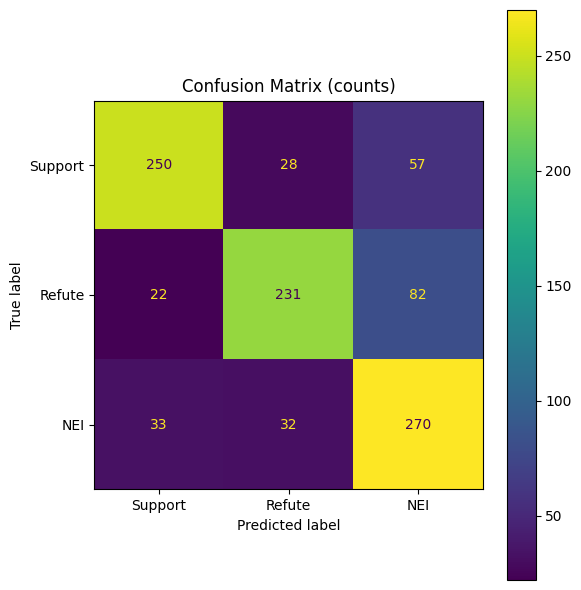

Done.


In [3]:
import os
import re
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Normalizer (your provided function)
# -----------------------------
def normalize_text(s):
    """Lower, strip, collapse whitespace, remove punctuation for EM/F1 normalization."""
    s = "" if s is None else s
    s = str(s).strip().lower()
    # Remove punctuation (same approach as many SQuAD eval scripts)
    s = re.sub(r"[^\w\s]", "", s)
    s = " ".join(s.split())
    return s

# -----------------------------
# Dataset class (same as training) with minor defensive coercion
# -----------------------------
class SentencePairDataset(Dataset):
    def __init__(self, sentence_pairs, labels, tokenizer, max_length):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentence_pairs)

    def __getitem__(self, idx):
        sentence1, sentence2 = self.sentence_pairs[idx]
        label = self.labels[idx]

        # Defensive: coerce to str to avoid tokenizer TypeError
        s1 = "" if sentence1 is None else str(sentence1)
        s2 = "" if sentence2 is None else str(sentence2)

        encoding = self.tokenizer.encode_plus(
            s1,
            text_pair=s2,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True,
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }

# -----------------------------
# NOTE: We no longer need a custom classifier class here because we load
# AutoModelForSequenceClassification from the Hub (same architecture used in training).
# -----------------------------

# -----------------------------
# Load test data (KEEP null/empty predicted evidence — do NOT drop)
# -----------------------------
def load_test_data(test_path, tokenizer, max_length=512):
    """
    Returns:
      - dataset (SentencePairDataset) where sentence pair = (claim, predicted_evidence_or_empty_string)
      - predicted_evidences_raw: list (same order) of original predicted evidence values (may be NaN)
      - gold_evidences_raw: list of original gold evidence values (may be NaN)
      - gold_labels_int: list of gold labels as ints
    """
    valid_labels = {"Support", "Refute", "NEI"}
    label_mapping = {"Support": 0, "Refute": 1, "NEI": 2}

    df = pd.read_csv(test_path)

    # Keep only rows with valid gold_label values
    df = df[df["gold_label"].isin(valid_labels)].reset_index(drop=True)

    # Map labels (convert to ints)
    df["gold_label_int"] = df["gold_label"].map(label_mapping)

    # Keep predicted evidence even if NaN — but the dataset will feed an empty string to tokenizer for NaN.
    # We keep both "raw" lists (can contain NaN) and also the strings used as input to the classifier.
    predicted_evidences_raw = df["evidence"].tolist() if "evidence" in df.columns else [None] * len(df)
    gold_evidences_raw = df["gold_evidence"].tolist() if "gold_evidence" in df.columns else [None] * len(df)

    # Build sentence pairs (claim, predicted_evidence_for_tokenizer) where we coerce NaN -> ""
    pred_evidence_for_input = df["evidence"].fillna("").astype(str).tolist()
    claims_for_input = df["claim"].fillna("").astype(str).tolist()
    sentence_pairs = list(zip(claims_for_input, pred_evidence_for_input))

    labels = df["gold_label_int"].tolist()

    dataset = SentencePairDataset(sentence_pairs, labels, tokenizer, max_length)
    return dataset, predicted_evidences_raw, gold_evidences_raw, labels

# -----------------------------
# Evaluate function (returns predictions and true labels)
# -----------------------------
def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []

    for batch in tqdm(dataloader, desc="Evaluating Test Set"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # extract logits from ModelOutput
            logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]
            _, predicted = torch.max(logits, dim=1)

        predictions.extend(predicted.cpu().numpy().tolist())
        true_labels.extend(labels.cpu().numpy().tolist())

    print("\nTest Set Classification Report (verdict classifier):")
    print(classification_report(true_labels, predictions, digits=4, target_names=["Support","Refute","NEI"]))
    return true_labels, predictions

# -----------------------------
# Metrics: ER, VC, Strict
# -----------------------------
def compute_er_vc_strict(y_true, y_pred, pred_evidences_raw, gold_evidences_raw):
    """
    Args:
      - y_true, y_pred: lists of ints (same order)
      - pred_evidences_raw: list (may contain NaN or None) predicted evidence strings
      - gold_evidences_raw: list (may contain NaN or None) gold evidence strings

    Behavior:
      - Normalizes text using normalize_text and compares for exact equality.
      - If predicted evidence is missing/empty and gold evidence is non-empty -> ER is considered incorrect.
      - If both predicted and gold are empty -> ER considered correct (they match after normalization).
    """
    N = len(y_true)
    assert N == len(y_pred) == len(pred_evidences_raw) == len(gold_evidences_raw)
    er_flags = []
    vc_flags = []
    strict_flags = []

    for i in range(N):
        pred_raw = pred_evidences_raw[i]
        gold_raw = gold_evidences_raw[i]

        # Detect null/empty in original columns
        pred_is_null = pd.isna(pred_raw) or str(pred_raw).strip() == "" or str(pred_raw).lower().strip() == "nan"

        # Normalized strings (coerce None->"")
        pred_norm = normalize_text("" if pred_raw is None or (isinstance(pred_raw, float) and np.isnan(pred_raw)) else pred_raw)
        gold_norm = normalize_text("" if gold_raw is None or (isinstance(gold_raw, float) and np.isnan(gold_raw)) else gold_raw)

        # ER correctness logic:
        # - if predicted is empty but gold is non-empty => incorrect (explicit requirement)
        # - else check normalized exact match
        if pred_is_null:
            er_correct = False
        else:
            er_correct = (pred_norm == gold_norm)

        vc_correct = (y_pred[i] == y_true[i])
        strict_correct = er_correct and vc_correct

        er_flags.append(er_correct)
        vc_flags.append(vc_correct)
        strict_flags.append(strict_correct)

    er_count = sum(er_flags)
    vc_count = sum(vc_flags)
    strict_count = sum(strict_flags)

    results = {
        "n": N,
        "er_count": er_count,
        "vc_count": vc_count,
        "strict_count": strict_count,
        "er_acc": er_count / N if N else 0.0,
        "vc_acc": vc_count / N if N else 0.0,
        "strict_acc": strict_count / N if N else 0.0,
        "er_flags": er_flags,
        "vc_flags": vc_flags,
        "strict_flags": strict_flags
    }
    return results

# -----------------------------
# Confusion matrix plotting helper (raw counts)
# -----------------------------
def plot_confusion_matrix_counts(y_true,
                                 y_pred,
                                 labels=None,
                                 figsize=(6,6),
                                 save_path=None):
    cm = confusion_matrix(y_true, y_pred)  # integer counts
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, values_format='d')
    ax.set_title("Confusion Matrix (counts)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Saved confusion matrix to: {save_path}")
    plt.show()

# -----------------------------
# MAIN: Load + Test + Compute ER/VC/Strict + Plot CM
# -----------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    TEST_PATH = "predictions_vinum_sliding_window_top_1.csv"

    # Config
    MAX_LENGTH = 512
    BATCH_SIZE = 8
    CM_SAVE_PATH = "/kaggle/working/confusion_matrix_counts.png"   # set to None if you don't want to save
    LABEL_NAMES = ["Support", "Refute", "NEI"]

    # -----------------------------
    # LOAD TOKENIZER + MODEL FROM HF repo (AutoModelForSequenceClassification)
    # -----------------------------
    HF_REPO_ID = "ICTuniverse/CafeBERT-FC-ViNumFC-88-Acc"   # public repo on HF containing tokenizer & model

    # Load tokenizer from Hub
    print("Loading tokenizer from HF repo:", HF_REPO_ID)
    tokenizer = AutoTokenizer.from_pretrained(HF_REPO_ID)

    # Load full sequence classification model from Hub
    print("Loading sequence classification model from HF repo:", HF_REPO_ID)
    model = AutoModelForSequenceClassification.from_pretrained(HF_REPO_ID)
    model.to(device)

    # Load test dataset + dataloader (KEEP rows with null predicted evidence)
    print("Loading test dataset from:", TEST_PATH)
    test_dataset, pred_evidences_raw, gold_evidences_raw, gold_labels_int = load_test_data(TEST_PATH, tokenizer, max_length=MAX_LENGTH)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Run evaluation (verdict classifier)
    y_true, y_pred = evaluate(model, test_loader, device)

    # After running evaluation and getting y_pred
    label_id2name = {0: "Support", 1: "Refute", 2: "NEI"}
    
    # Load original CSV again (to keep same order and all columns)
    df_test = pd.read_csv(TEST_PATH)
    
    # Map predicted IDs back to label names
    pred_labels = [label_id2name[i] for i in y_pred]
    
    # Attach to the same filtered dataframe used in evaluation
    df_filtered = df_test[df_test["gold_label"].isin(["Support", "Refute", "NEI"])].reset_index(drop=True)
    df_filtered["pred_label"] = pred_labels
    
    # Save as new CSV
    SAVE_PATH = "/kaggle/working/test_with_predictions.csv"
    df_filtered.to_csv(SAVE_PATH, index=False)
    print(f"\nSaved predictions to: {SAVE_PATH}")

    # Compute ER / VC / Strict
    metrics = compute_er_vc_strict(y_true, y_pred, pred_evidences_raw, gold_evidences_raw)
    print("\n=== Retrieval / Verdict / Strict Summary ===")
    print(f"Total samples evaluated: {metrics['n']}")
    print(f"ER correct: {metrics['er_count']} / {metrics['n']}  (ER acc = {metrics['er_acc']:.4f})")
    print(f"VC correct: {metrics['vc_count']} / {metrics['n']}  (VC acc = {metrics['vc_acc']:.4f})")
    print(f"Strict correct (both ER & VC): {metrics['strict_count']} / {metrics['n']}  (Strict acc = {metrics['strict_acc']:.4f})")

    # Plot confusion matrix with raw counts (no normalization, integer display)
    if len(y_true) == 0 or len(y_pred) == 0:
        print("No predictions/labels to build confusion matrix.")
    else:
        plot_confusion_matrix_counts(y_true, y_pred, labels=LABEL_NAMES, figsize=(6,6), save_path=CM_SAVE_PATH)

    print("Done.")


# PREDICTIONS TOP K, SLIDING WINDOWS, ViNumFC

**Có 3 đoạn code dưới mục này**
1. format file (lấy top 2)
2. MRC
3. CLS (lấy evidence nào cho label khác NEI đầu tiên)

In [30]:
import pandas as pd

# paths
TEST_CSV = "/kaggle/input/vinumfc-formatted/test_vinum_formatted.csv"
RANKINGS_TXT = "/kaggle/input/rankings-3-vinum/rankings_3_vinum.txt"
OUT_CSV = "vinum_test_with_top2_cids.csv"

# load test file
test_df = pd.read_csv(TEST_CSV)

# parse rankings: each line "qid cid1 cid2 ..."
rankings = {}
with open(RANKINGS_TXT, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split()
        qid = int(parts[0])
        cids = [int(x) for x in parts[1:]]
        rankings[qid] = cids

# determine qid per test row: use column 'qid' if present, otherwise 1-based row index
qid_col = None  # change if your CSV has a 'qid' column

out_rows = []
for i, row in test_df.iterrows():
    qid = int(row[qid_col]) if qid_col is not None else (i + 1)
    top10_cids = rankings[qid][:2]  # get top-10 cids

    out_rows.append({
        "claim": row["claim"],
        "cid": top10_cids,
        "evidence": row["evidence"],
        "gold_label": row["gold_label"]
    })

out_df = pd.DataFrame(out_rows)
out_df.to_csv(OUT_CSV, index=False)
print("Wrote:", OUT_CSV)


Wrote: vinum_test_with_top2_cids.csv


In [32]:
import os
import re
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# -------------------
# CONFIG
# -------------------
model_name = "ICTuniverse/CafeBERT-QA-vinum-7532-EM"
HF_TOKEN = ""
TEST_CSV = "/kaggle/working/vinum_test_with_top2_cids.csv"  # your input with claim + cid
CORPUS_CSV = "/kaggle/input/raw-ir-vinum/corpus.csv"
OUT_CSV = "predictions_vinum_sliding_window_top_2.csv"
device = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LENGTH = 512

# Sliding window parameters
WINDOW_SIZE = 480
MIN_STRIDE = 200

# -------------------
# Load model + tokenizer
# -------------------
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, token=HF_TOKEN)
model = AutoModelForQuestionAnswering.from_pretrained(model_name, token=HF_TOKEN)
model.to(device)
model.eval()

# -------------------
# Load corpus
# -------------------
corpus_df = pd.read_csv(CORPUS_CSV)
cid2context = dict(zip(corpus_df['cid'], corpus_df['context']))

# -------------------
# Utilities
# -------------------
def normalize_for_em(s):
    if s is None:
        s = ""
    s = str(s).strip().lower()
    s = re.sub(r"[^\w\s]", "", s)
    s = " ".join(s.split())
    return s

def exact_match(pred, gold):
    return int(normalize_for_em(pred) == normalize_for_em(gold))

def tok_len_pair(claim, context):
    return tokenizer(claim, context, truncation=False, add_special_tokens=True, padding=False, return_length=True)["length"][0]

def context_ids_no_specials(text):
    return tokenizer(text, add_special_tokens=False)["input_ids"]

def decode_ids(ids):
    return tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

# -------------------
# Sliding window splitter
# -------------------
def create_subcontexts_sliding_window(claim, context, max_len=MAX_LENGTH):
    if tok_len_pair(claim, context) <= max_len:
        return [context.strip()]

    ctx_ids = context_ids_no_specials(context)
    claim_tok_len = len(tokenizer(claim, add_special_tokens=False)["input_ids"])
    reserve = claim_tok_len + 3
    window_size = min(WINDOW_SIZE, max_len - reserve)
    stride = max(MIN_STRIDE, int(window_size * 0.33))
    step = window_size - stride
    if step <= 0:
        step = max(1, window_size // 2)

    subcontexts = []
    for start in range(0, len(ctx_ids), step):
        end = start + window_size
        window_ids = ctx_ids[start:end]
        window_text = decode_ids(window_ids)

        while tok_len_pair(claim, window_text) > max_len and len(window_ids) > 0:
            window_ids = window_ids[:-1]
            window_text = decode_ids(window_ids)

        if window_text.strip():
            subcontexts.append(window_text.strip())
    return subcontexts

# -------------------
# Answering function
# -------------------
def answer_question(question: str, context: str, max_length=MAX_LENGTH):
    encodings = tokenizer(
        question,
        context,
        return_tensors="pt",
        truncation="only_second",
        max_length=max_length,
        return_offsets_mapping=True,
        padding=True,
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    offset_mapping = encodings["offset_mapping"][0]

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

    start_idx = torch.argmax(start_logits, dim=1).item()
    end_idx = torch.argmax(end_logits, dim=1).item()
    if end_idx < start_idx:
        end_idx = start_idx

    start_char, _ = offset_mapping[start_idx].tolist()
    _, end_char = offset_mapping[end_idx].tolist()
    return context[start_char:end_char].strip()

# -------------------
# Run test on multiple cids per claim
# -------------------
def run_sliding_window_test_multicid(test_csv, out_csv):
    df = pd.read_csv(test_csv)
    required_cols = {"claim", "cid", "evidence", "gold_label"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing columns. Expected at least {required_cols}, found {df.columns.tolist()}")

    results = []
    em_total = 0
    n = len(df)

    for _, row in tqdm(df.iterrows(), total=n, desc="Predicting"):
        claim = str(row["claim"])
        cids = eval(row["cid"])  # e.g., [7, 132, 377, ...]
        gold_label = row.get("gold_label", "")
        gold_evidence = row.get("evidence", "")

        pred_evidences = []
        for cid in cids:
            context = cid2context.get(cid, "")
            if not context:
                pred_evidences.append("")
                continue

            if tok_len_pair(claim, context) <= MAX_LENGTH:
                pred_evidence = answer_question(claim, context)
            else:
                subcontexts = create_subcontexts_sliding_window(claim, context)
                pred_evidence = ""
                for subctx in subcontexts:
                    try:
                        seg_pred = answer_question(claim, subctx)
                    except Exception:
                        seg_pred = ""
                    if seg_pred.strip() and len(seg_pred.strip().split()) > 10:
                        pred_evidence = seg_pred
                        break
            pred_evidences.append(pred_evidence)

        results.append({
            "claim": claim,
            "cid": cids,
            "evidence": pred_evidences,
            "gold_evidence": gold_evidence,
            "gold_label": gold_label
        })

        # Compute EM across first retrieved evidence as optional
        if isinstance(gold_evidence, str) and pred_evidences:
            em_total += exact_match(pred_evidences[0], gold_evidence)

    em_score = em_total / n if n > 0 else 0.0
    print(f"\nExact Match (first retrieved context) on {n} examples: {em_score:.4f} ({int(em_total)}/{n})")

    out_df = pd.DataFrame(results, columns=["claim", "cid", "evidence", "gold_evidence", "gold_label"])
    out_df.to_csv(out_csv, index=False, encoding="utf-8")
    print(f"Saved {len(out_df)} rows to {out_csv}")


if __name__ == "__main__":
    run_sliding_window_test_multicid(TEST_CSV, OUT_CSV)


Predicting: 100%|██████████| 1005/1005 [04:50<00:00,  3.46it/s]



Exact Match (first retrieved context) on 1005 examples: 0.6348 (638/1005)
Saved 1005 rows to predictions_vinum_sliding_window_top_10.csv


In [33]:
temp = pd.read_csv("predictions_vinum_sliding_window_top_10.csv")

Device: cuda


Evaluating multi-evidence: 100%|██████████| 1005/1005 [01:55<00:00,  8.68it/s]



=== Retrieval / Verdict / Strict Summary ===
Total samples: 1005
ER correct: 640  (ER acc = 0.6368)
VC correct: 755  (VC acc = 0.7512)
Strict correct: 566  (Strict acc = 0.5632)


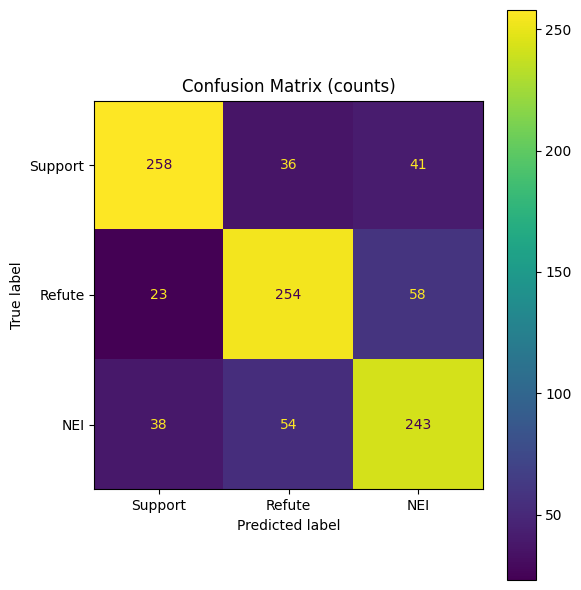

Saved final predictions to: /kaggle/working/test_with_final_predictions.csv


In [35]:
import os
import re
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Normalizer
# -----------------------------
def normalize_text(s):
    s = "" if s is None else str(s)
    s = s.strip().lower()
    s = re.sub(r"[^\w\s]", "", s)
    s = " ".join(s.split())
    return s

# -----------------------------
# Dataset for single (claim, evidence)
# -----------------------------
class SentencePairDataset(Dataset):
    def __init__(self, sentence_pairs, tokenizer, max_length=512):
        self.sentence_pairs = sentence_pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentence_pairs)

    def __getitem__(self, idx):
        s1, s2 = self.sentence_pairs[idx]
        s1 = "" if s1 is None else str(s1)
        s2 = "" if s2 is None else str(s2)

        encoding = self.tokenizer.encode_plus(
            s1,
            text_pair=s2,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt",
            truncation=True
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
        }

# -----------------------------
# Predict function for multiple evidences per claim
# -----------------------------
def predict_final_label(model, tokenizer, claim, evidences_list, device, max_length=512, batch_size=8):
    """
    Args:
        claim: str
        evidences_list: list of str
    Returns:
        final_label_id (int), final_pred_evidence (str)
    """
    if not evidences_list or len(evidences_list) == 0:
        return 2, ""  # NEI by default

    # Prepare dataset
    sentence_pairs = [(claim, evi) for evi in evidences_list]
    dataset = SentencePairDataset(sentence_pairs, tokenizer, max_length)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Predict each evidence
    model.eval()
    preds = []
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1).cpu().tolist()
            preds.extend(batch_preds)

    # Select first non-NEI
    for idx, p in enumerate(preds):
        if p != 2:  # NEI=2
            return p, evidences_list[idx]
    # if all NEI
    return 2, evidences_list[0]

# -----------------------------
# Evaluation over dataset
# -----------------------------
def evaluate_multievidence(test_csv, model, tokenizer, device, max_length=512, batch_size=8):
    df = pd.read_csv(test_csv)
    valid_labels = ["Support","Refute","NEI"]
    label_name2id = {"Support":0,"Refute":1,"NEI":2}
    label_id2name = {v:k for k,v in label_name2id.items()}

    true_labels, pred_labels, final_evidences = [], [], []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating multi-evidence"):
        claim = str(row["claim"])
        gold_label = row["gold_label"]
        gold_label_id = label_name2id[gold_label]
        evidence_list = row["evidence"]
        # Convert string representation of list to actual list
        if isinstance(evidence_list, str):
            evidence_list = eval(evidence_list)

        pred_label_id, final_pred_evi = predict_final_label(
            model, tokenizer, claim, evidence_list, device, max_length=max_length, batch_size=batch_size
        )

        true_labels.append(gold_label_id)
        pred_labels.append(pred_label_id)
        final_evidences.append(final_pred_evi)

    return true_labels, pred_labels, final_evidences

# -----------------------------
# Compute ER/VC/Strict
# -----------------------------
def compute_er_vc_strict(y_true, y_pred, final_evidences, gold_evidences):
    N = len(y_true)
    er_flags, vc_flags, strict_flags = [], [], []

    for i in range(N):
        gold_evi = "" if pd.isna(gold_evidences[i]) else str(gold_evidences[i])
        pred_evi = "" if final_evidences[i] is None else str(final_evidences[i])

        # ER
        er_flags.append(normalize_text(pred_evi) == normalize_text(gold_evi))
        # VC
        vc_flags.append(y_pred[i] == y_true[i])
        # Strict
        strict_flags.append(er_flags[-1] and vc_flags[-1])

    results = {
        "n": N,
        "er_count": sum(er_flags),
        "vc_count": sum(vc_flags),
        "strict_count": sum(strict_flags),
        "er_acc": sum(er_flags)/N if N else 0.0,
        "vc_acc": sum(vc_flags)/N if N else 0.0,
        "strict_acc": sum(strict_flags)/N if N else 0.0,
        "er_flags": er_flags,
        "vc_flags": vc_flags,
        "strict_flags": strict_flags
    }
    return results

# -----------------------------
# Confusion matrix plotting
# -----------------------------
def plot_confusion_matrix_counts(y_true, y_pred, labels=None, figsize=(6,6), save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, values_format='d')
    ax.set_title("Confusion Matrix (counts)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# -----------------------------
# MAIN
# -----------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    TEST_PATH = "predictions_vinum_sliding_window_top_10.csv"
    HF_REPO_ID = "ICTuniverse/CafeBERT-FC-ViNumFC-88-Acc"
    BATCH_SIZE = 8
    MAX_LENGTH = 512

    # Load tokenizer + model
    tokenizer = AutoTokenizer.from_pretrained(HF_REPO_ID)
    model = AutoModelForSequenceClassification.from_pretrained(HF_REPO_ID)
    model.to(device)

    # Load gold evidences
    df_test = pd.read_csv(TEST_PATH)
    gold_evidences_raw = df_test["gold_evidence"].tolist()
    gold_labels = df_test["gold_label"].tolist()

    # Evaluate
    y_true, y_pred, final_evidences = evaluate_multievidence(
        TEST_PATH, model, tokenizer, device, max_length=MAX_LENGTH, batch_size=BATCH_SIZE
    )

    # Compute metrics
    metrics = compute_er_vc_strict(y_true, y_pred, final_evidences, gold_evidences_raw)
    print("\n=== Retrieval / Verdict / Strict Summary ===")
    print(f"Total samples: {metrics['n']}")
    print(f"ER correct: {metrics['er_count']}  (ER acc = {metrics['er_acc']:.4f})")
    print(f"VC correct: {metrics['vc_count']}  (VC acc = {metrics['vc_acc']:.4f})")
    print(f"Strict correct: {metrics['strict_count']}  (Strict acc = {metrics['strict_acc']:.4f})")

    # Confusion matrix
    LABEL_NAMES = ["Support","Refute","NEI"]
    plot_confusion_matrix_counts(y_true, y_pred, labels=LABEL_NAMES, figsize=(6,6))

    # Save predictions
    df_test["pred_label"] = [ ["Support","Refute","NEI"][i] for i in y_pred ]
    df_test["final_pred_evidence"] = final_evidences
    SAVE_PATH = "/kaggle/working/test_with_final_predictions.csv"
    df_test.to_csv(SAVE_PATH, index=False)
    print(f"Saved final predictions to: {SAVE_PATH}")


In [21]:
test_temp = pd.read_csv("test_with_final_predictions.csv")

In [29]:
test_temp.iloc[0]['evidence']

"['Lần đầu tiên kể từ năm 2017 và là lần thứ hai trong lịch sử, Việt Nam có một đô cử vô địch thế giới. Bởi sáu năm trước ở Mỹ, Thạch Kim Tuấn cũng đoạt cả ba HC vàng hạng 56kg, với thành tích giật 126 kg, đẩy 153 kg và 279 kg tổng cử. Khi đó, một võ sĩ Việt Nam khác là Trần Lê Quốc Toàn cũng đoạt cả ba HC bạc hạng cân này.', 'Giải bóng chuyền nữ vô địch châu Á 2023 tổ chức tại Thái Lan từ 30/8 đến 6/9 với 14 đội tham dự. Sau 20 lần tổ chức, Trung Quốc dẫn đầu với 13 chức vô địch, xếp sau là Nhật Bản (5) và Thái Lan (2). Thành tích tốt nhất của Việt Nam ở giải là hai lần đứng thứ năm vào năm 2015 và 2017.', 'Tiến Minh lần thứ 15 vô địch giải cầu lông cá nhân quốc gia, trong đó có kỷ lục 11 năm liền đăng quang giai đoạn 2002-2013. Chuỗi này chỉ dừng ở năm 2014 bởi anh không tham dự. Sau đó, anh vô địch quốc gia thêm bốn lần nữa năm 2017, 2019, 2020 và 2023. Điều đặc biệt là trong 20 năm qua, Tiến Minh mỗi khi dự giải đều vào chung kết.']"